In [1]:
# Jason Wang
# December 10th, 2021

### Imports and Declarations

In [1]:
import cv2
import mediapipe as mp
import os
from scipy.stats import norm
from scipy.signal import savgol_filter
import math
import numpy as np
import urllib
import time
import threading
import matplotlib.pyplot as plt 
from scipy.interpolate import barycentric_interpolate
from scipy import interpolate
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

### Functions

In [2]:
def getAngle3D(results, a, b, c):
    """
    Calculates the angle between three points baed on the number given in the figure
    
    Parameters:
    results : Processed Mediapipe
    a (int): Number given to the first joint 
    b (int): Number given to the second or main joint 
    c (int): Number given to the third joint
    
    Returns:
    output: The angle rounded to two decimal points
    """
    
    v1 = [results.pose_landmarks.landmark[a].x - results.pose_landmarks.landmark[b].x,
          results.pose_landmarks.landmark[a].y - results.pose_landmarks.landmark[b].y,
          results.pose_landmarks.landmark[a].z - results.pose_landmarks.landmark[b].z]
    v2 = [results.pose_landmarks.landmark[c].x - results.pose_landmarks.landmark[b].x,
          results.pose_landmarks.landmark[c].y - results.pose_landmarks.landmark[b].y,
          results.pose_landmarks.landmark[c].z - results.pose_landmarks.landmark[b].z]
    v1mag = np.sqrt(np.square(v1[0]) + np.square(v1[1]) + np.square(v1[2]))
    v2mag = np.sqrt(np.square(v2[0]) + np.square(v2[1]) + np.square(v2[2]))
    v1norm = [x / v1mag for x in v1]
    v2norm = [x / v2mag for x in v2]
    res = v1norm[0]*v2norm[0] + v1norm[1]*v2norm[1] + v1norm[2]*v2norm[2]
    output = np.arccos(res)
    angle = round(math.degrees(output),2)
    return angle 

In [3]:
def getAngle(results, a, b, c):
    """
    Calculates the angle between three points baed on the number given in the figure using just 
    the x and y coordinates
    
    
    Parameters:
    results : Processed Mediapipe
    a (int): Number given to the first joint 
    b (int): Number given to the second or main joint 
    c (int): Number given to the third joint
    
    Returns:
    output: The angle rounded to two decimal points
    """
    v1 = [results.pose_landmarks.landmark[b].x - results.pose_landmarks.landmark[a].x,
          results.pose_landmarks.landmark[b].y - results.pose_landmarks.landmark[a].y]
    v2 = [results.pose_landmarks.landmark[b].x - results.pose_landmarks.landmark[c].x,
          results.pose_landmarks.landmark[b].y - results.pose_landmarks.landmark[c].y]
    dot = v1[0] * v2[0] + v1[1] * v2[1]
    v1mag = np.sqrt(np.square(v1[0]) + np.square(v1[1]))
    v2mag = np.sqrt(np.square(v2[0]) + np.square(v2[1]))
    res = dot/(v1mag * v2mag)
    output = np.arccos(res)
    angle = round(math.degrees(output),2)
    return angle 
    

In [4]:
def getCoordinate(results, b):
    """
    Returns the coordinate of the second or main joint
    
    Parameters:
    results : Processed Mediapipe
    b (int): Number given to the second or main joint 
    
    Returns:
    coordinate: The x, y coordinate of the second or main joint
    """
    coordinate = [results.pose_landmarks.landmark[b].x, results.pose_landmarks.landmark[b].y]
    return coordinate

In [5]:
def getVisibility(results, a, b, c):
    """
    Calculates the visibility between three points baed on the number given in the figure by averaging the all the visibility values
    
    Parameters:
    results : Processed Mediapipe
    a (int): Number given to the first joint 
    b (int): Number given to the second or main joint 
    c (int): Number given to the third joint
    
    Returns:
    visibility: The average visibility of all the joints
    """
    output = (results.pose_landmarks.landmark[a].visibility + results.pose_landmarks.landmark[b].visibility + results.pose_landmarks.landmark[c].visibility)/3
    visibility = round(output,2)
    return visibility

In [6]:
def normalizeAngles(results):
    """
    Returns the angles of the most important joints in the body during the motion.
    
    Parameters:
    results : Processed Mediapipe image
    
    Returns:
    output : List of angle values ordered by [right hand, left hand, right elbow, left elbow, right hip, left hip, right knee, left knee, right foot, left foot]
    
    """
    rightHand = getAngle(results, 20, 16, 14)
    leftHand = getAngle(results, 19, 15, 13)
    rightElbow = getAngle(results, 16, 14, 12)
    leftElbow = getAngle(results, 15, 13, 11)
    rightHip = getAngle(results, 26, 24, 12)
    leftHip = getAngle(results, 25, 23, 11)
    rightKnee = getAngle(results, 28, 26 ,24)
    leftKnee = getAngle(results, 27, 25, 23)
    rightFoot = getAngle(results, 32, 28, 26)
    leftFoot = getAngle(results, 31, 27, 25)
    output = [rightHand, leftHand, rightElbow, leftElbow, rightHip, leftHip, rightKnee, leftKnee, rightFoot, leftFoot]
    return output

In [7]:
def initiateList():
    output = [[],[],[],[],[],[],[],[],[],[]]
    return output

In [8]:
def normalizeAngles(results, listAngles):
    """
    Returns the angles of the most important joints in the body during the motion.
    
    Parameters:
    listAngles
    results : Processed Mediapipe image
    
    Returns:
    output : List of angle values ordered by [right hand, left hand, right elbow, left elbow, right hip, left hip, right knee, left knee, right foot, left foot]
    
    """
    listAngles[0].append(getAngle(results, 20, 16, 14))
    listAngles[1].append(getAngle(results, 19, 15, 13))
    listAngles[2].append(getAngle(results, 16, 14, 12))
    listAngles[3].append(getAngle(results, 15, 13, 11))
    listAngles[4].append(getAngle(results, 26, 24, 12))
    listAngles[5].append(getAngle(results, 25, 23, 11))
    listAngles[6].append(getAngle(results, 28, 26 ,24))
    listAngles[7].append(getAngle(results, 27, 25, 23))
    listAngles[8].append(getAngle(results, 32, 28, 26))
    listAngles[9].append(getAngle(results, 31, 27, 25))
    return True

In [9]:
def normalizeVisibilities(results, listVisibilities):
    """
    Returns the angles of the most important joints in the body during the motion.
    
    Parameters:
    results : Processed Mediapipe image
    
    Returns:
    output : List of angle values ordered by [right hand, left hand, right elbow, left elbow, right hip, left hip, right knee, left knee, right foot, left foot]
    
    """
    listVisibilities[0].append(getVisibility(results, 20, 16, 14))
    listVisibilities[1].append(getVisibility(results, 19, 15, 13))
    listVisibilities[2].append(getVisibility(results, 16, 14, 12))
    listVisibilities[3].append(getVisibility(results, 15, 13, 11))
    listVisibilities[4].append(getVisibility(results, 26, 24, 12))
    listVisibilities[5].append(getVisibility(results, 25, 23, 11))
    listVisibilities[6].append(getVisibility(results, 28, 26 ,24))
    listVisibilities[7].append(getVisibility(results, 27, 25, 23))
    listVisibilities[8].append(getVisibility(results, 32, 28, 26))
    listVisibilities[9].append(getVisibility(results, 31, 27, 25))
    return True

In [10]:
def listVisibilities(results, angles):
    """
    Returns the angles of the most important joints in the body during the motion.
    
    Parameters:
    results : Processed Mediapipe image
    
    Returns:
    output : List of angle values ordered by [right hand, left hand, right elbow, left elbow, right hip, left hip, right knee, left knee, right foot, left foot]
    
    """
    rightHand = getVisibility(results, 20, 16, 14)
    leftHand = getVisibility(results, 19, 15, 13)
    rightElbow = getVisibility(results, 16, 14, 12)
    leftElbow = getVisibility(results, 15, 13, 11)
    rightHip = getVisibility(results, 26, 24, 12)
    leftHip = getVisibility(results, 25, 23, 11)
    rightKnee = getVisibility(results, 28, 26 ,24)
    leftKnee = getVisibility(results, 27, 25, 23)
    rightFoot = getVisibility(results, 32, 28, 26)
    leftFoot = getVisibility(results, 31, 27, 25)
    output = [rightHand, leftHand, rightElbow, leftElbow, rightHip, leftHip, rightKnee, leftKnee, rightFoot, leftFoot]
    return output

In [11]:
def savgolSmoothing(angles, window, poly):
    """
    Returns a list of angles that have been smoothed with Savitzky_golay Filtering
    
    Parameters:
    angles : List of raw angle values
    window : Int of how many frames to smooth by 
    poly: Polynomial of smoothing
    
    Returns:
    output : List of smoothed angle values
    
    """
    output = []
    for i in angles:
        output.append(savgol_filter(i, window, poly))
    return output

In [12]:
def distributionDifference(distOne, distTwo):
    diff = 0
    for i in range(len(distOne)):
        for j in range(len(distOne[i])):
            diff += math.pow((distOne[i][j]-distTwo[i][j]), 2)
    return diff

In [13]:
def reduceDistribution(dist, delayFrames, targetLength):
    temp = initiateList()
    for i in range(len(dist)):
        temp[i] = (dist[i][delayFrames:delayFrames+targetLength])
    return temp

In [14]:
def syncCameras(distOne, distTwo):
    """
    Returns the smallest difference in angles based on frames 
    Condition: Side must be small and fit into back
    
    Parameters:
    framesWebcam: A list of frames from the back
    framesPhone: A list of frames from the side
    
    Returns:
    output : The time difference between the two frames
    
    """
    frameDifference = len(distOne[0]) - len(distTwo[0])
    minDiff = math.pow(10, 10)
    frameDiff = 0
    start = 0
    end = len(distTwo[0])
    for i in range(frameDifference):
        reducedSide = reduceDistribution(distOne, i, len(distTwo[0]))
        difference = distributionDifference(reducedSide, sideAngles)
        if difference < minDiff:
            frameDiff = i
            minDiff = difference
            start = i
    return frameDiff

In [15]:
def combineDistributions(distOne, distTwo, visibilitiesOne, visibilitiesTwo):
    if (len(distOne[0]) != len(distTwo[0])):
        print('Distributions different length!')
        return False 
    if (len(visibilitiesOne[0]) != len(visibilitiesTwo[0])):
        print('Visibiilities different length!')
        return False 
    tempAngles = initiateList()
    tempVisibilities = initiateList()
    for i in range(len(distOne)):
        for j in range(len(distOne[i])):
            diff = distTwo[i][j] - distOne[i][j]
            combineVisibilities = visibilitiesOne[i][j] + visibilitiesTwo[i][j]
            tempVisibilities[i].append(combineVisibilities/2)
            percentage = visibilitiesTwo[i][j]/combineVisibilities
            change = diff * percentage
            tempAngles[i].append(distOne[i][j] + change)
    tempAngles = savgolSmoothing(tempAngles, 49, 3)
    return tempAngles, tempVisibilities

In [16]:
def changeDistribution(dist, size):
    x_observed = np.linspace(0.0, size, len(dist))
    y_observed = dist
    f = interpolate.interp1d(x_observed,y_observed)
    x = np.linspace(0, 1000, size)
    y = f(x).tolist()
    return y

In [17]:
def analyzeData(rootdir):
    masterAngles = []
    masterVisibilities = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            path = os.path.join(subdir, file)
            if path.endswith('.mp4'):
                video_cap = cv2.VideoCapture(path)
                videoAngles = initiateList()
                videoVisibilities = initiateList()
                video_n_frames = video_cap.get(cv2.CAP_PROP_FRAME_COUNT)
                videoCount = 0
                with mp_pose.Pose(static_image_mode=False,model_complexity=2,min_detection_confidence=0.0) as pose:
                    while video_cap.isOpened():
                        try:
                            video_ret, video_frame = video_cap.read()
                            video_result = pose.process(video_frame)
                            normalizeAngles(video_result, videoAngles)
                            normalizeVisibilities(video_result, videoVisibilities)
                            previous_video_result = video_result
                        except:
                            normalizeAngles(previous_video_result, videoAngles)
                            normalizeVisibilities(previous_video_result, videoVisibilities)
                            pass
                        videoCount += 1
                        if (videoCount >= video_n_frames):
                            break
                masterAngles.append(videoAngles)
                masterVisibilities.append(videoVisibilities)
    return masterAngles, masterVisibilities

                

In [18]:
def combineData(masterAngles, masterVisibilities):
    standardized = []
    count = 0
    standardizedAngles = []
    standardizedVisibilities = []
    for i in range(len(masterAngles)):
        tempAngles = []
        tempVisibilities = []
        for j in range(len(masterAngles[i])):
            tempAngles.append(changeDistribution(masterAngles[i][j], 1000))
            tempVisibilities.append(changeDistribution(masterVisibilities[i][j], 1000))
        standardizedAngles.append(tempAngles)
        standardizedVisibilities.append(tempVisibilities)
    combinedOneAngles, combinedOneVisibilities = combineDistributions(standardizedAngles[0], standardizedAngles[1], standardizedVisibilities[0], standardizedVisibilities[1])
    combinedTwoAngles, combinedTwoVisibilities = combineDistributions(standardizedAngles[2], standardizedAngles[3], standardizedVisibilities[2], standardizedVisibilities[3])
    combinedThreeAngles, combinedThreeVisibilities = combineDistributions(standardizedAngles[4], standardizedAngles[5], standardizedVisibilities[4], standardizedVisibilities[5])
    combinedFourAngles, combinedFourVisibilities = combineDistributions(standardizedAngles[6], standardizedAngles[7], standardizedVisibilities[6], standardizedVisibilities[7])
    combinedOneAngles, combinedOneVisibilities = combineDistributions(combinedOneAngles, combinedTwoAngles, combinedOneVisibilities, combinedTwoVisibilities)
    combinedTwoAngles, combinedTwoVisibilities = combineDistributions(combinedThreeAngles, combinedFourAngles, combinedThreeVisibilities, combinedFourVisibilities)
    dataAngles, dataVisibilities = combineDistributions(combinedOneAngles, combinedTwoAngles, combinedOneVisibilities, combinedTwoVisibilities)
    dataAngles = savgolSmoothing(dataAngles, 49, 3)
    dataVisibilities = savgolSmoothing(dataVisibilities, 49, 3)
    return dataAngles, dataVisibilities
            

In [19]:
def matchFinal(distOne, distTwo):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-19-a76681e7b53a>, line 2)

### Analyzing Videos

In [15]:
# Video Characteristics
video_path = '/Users/jasonwang/Academics/Data Science/Personal Projects/myTennis/'
back = 'back.mp4'
side = 'side.mp4'
side_cap = cv2.VideoCapture(video_path + side)
back_cap = cv2.VideoCapture(video_path + back)
#video_n_frames = video_cap.get(cv2.CAP_PROP_FRAME_COUNT)
side_cap.get(cv2.CAP_PROP_FPS)
#video_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#video_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

119.83866243679005

In [19]:
video_path = '/Users/jasonwang/Academics/Data Science/Personal Projects/myTennis/'
back = 'back.mp4'
side = 'side.mp4'
side_cap = cv2.VideoCapture(video_path + side)
back_cap = cv2.VideoCapture(video_path + back)
back_n_frames = back_cap.get(cv2.CAP_PROP_FRAME_COUNT)
side_n_frames = side_cap.get(cv2.CAP_PROP_FRAME_COUNT)
backAngles = initiateList()
sideAngles = initiateList()
backVisibilities = initiateList()
sideVisibilities = initiateList()
backCount = 0
sideCount = 0
with mp_pose.Pose(static_image_mode=False,model_complexity=2,min_detection_confidence=0.0) as pose:
    while back_cap.isOpened() or side_cap.isOpened():
        try:
            back_ret, back_frame = back_cap.read()
            back_result = pose.process(back_frame)
            normalizeAngles(back_result, backAngles)
            normalizeVisibilities(back_result, backVisibilities)
            previous_back_result = back_result
        except:
            normalizeAngles(previous_back_result, backAngles)
            normalizeVisibilities(previous_back_result, backVisibilities)
            pass
        backCount += 1
        if (backCount >= back_n_frames):
            break
with mp_pose.Pose(static_image_mode=False,model_complexity=2,min_detection_confidence=0.0) as pose:
    while back_cap.isOpened() or side_cap.isOpened():
        try:
            side_ret, side_frame = side_cap.read()
            side_result = pose.process(side_frame)
            normalizeAngles(side_result, sideAngles)
            normalizeVisibilities(side_result, sideVisibilities)
            previous_side_result = side_result
        except:
            normalizeAngles(previous_side_result, sideAngles)
            normalizeVisibilities(previous_side_result, sideVisibilities)
            pass
        sideCount += 1
        if sideCount >= side_n_frames:
            break
back_cap.release()
side_cap.release()
cv2.destroyAllWindows()

In [20]:
print(len(backAngles[0]))
print(back_n_frames)
print(side_n_frames)
print(len(sideAngles[0]))

982
982.0
566.0
566


In [31]:
smoothedBack = savgolSmoothing(backAngles, 49, 3)
smoothedSide = savgolSmoothing(sideAngles, 49, 3)
video_path = '/Users/jasonwang/Academics/Data Science/Personal Projects/myTennis/'
back = 'back.mp4'
side = 'side.mp4'
side_cap = cv2.VideoCapture(video_path + side)
back_cap = cv2.VideoCapture(video_path + back)
back_n_frames = back_cap.get(cv2.CAP_PROP_FRAME_COUNT)
side_n_frames = side_cap.get(cv2.CAP_PROP_FRAME_COUNT)
delay = syncCameras(smoothedBack, smoothedSide)
count = 0
while count < delay:
    back_ret, back_frame = back_cap.read()
    count += 1
while back_cap.isOpened() or side_cap.isOpened():
    back_ret, back_frame = back_cap.read()
    side_ret, side_frame = side_cap.read()
    if not back_ret and not side_ret:
        print("Can't receive frame (stream end?). Exiting ...")
        continue
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
    if key == ord('p'):
        cv2.waitKey(-1) 
    try:
        combined = np.concatenate((back_frame, side_frame), axis=1)
        cv2.imshow('frame', combined)
    except:
        break
back_cap.release()
side_cap.release()
cv2.destroyAllWindows()

In [21]:
reducedBackAngles = reduceDistribution(smoothedBack, delay, len(sideAngles[0]))
reducedBackVisibilities = reduceDistribution(backVisibilities, delay, len(sideVisibilities[0]))

In [22]:
combinedAngles, combinedVisibilities = combineDistributions(reducedBackAngles, smoothedSide, reducedBackVisibilities, sideVisibilities)

In [23]:
path = "/Users/jasonwang/Academics/Data Science/Personal Projects/Data/"
Angles, Visibilities = analyzeData(path)

In [24]:
federerAngles, federerVisibilities = combineData(Angles, Visibilities)

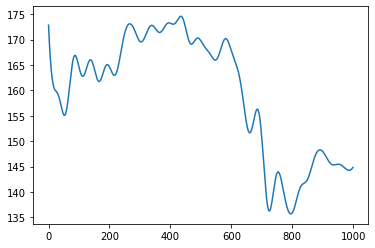

In [34]:

plt.plot(federerAngles[1])
plt.show()

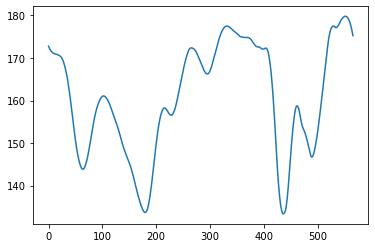

In [35]:
plt.plot(combinedAngles[1])

In [39]:
expandedAngles = []
for i in range(len(combinedAngles)):
    temp = changeDistribution(combinedAngles[i], 2000)
    expandedAngles.append(temp)

In [41]:
print(syncCameras(combinedAngles, federerAngles))

0
